In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 6.7 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from deap import base, creator, tools, algorithms
import random

In [ ]:
df_price = pd.read_excel("/content/drive/MyDrive/ts_data/AAPL_price_2010_2025.xlsx")
df_earnings = pd.read_excel("/content/drive/MyDrive/ts_data/10to25_AAPL_Earning_Data.xlsx")

In [ ]:
print(df_price.shape)
print(df_earnings.shape)

(3774, 8)
(66, 4)


In [ ]:
df_price.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2010-01-04,6.422877,6.455077,6.391278,6.440331,493729600,0.0,0
1,2010-01-05,6.458085,6.487878,6.417459,6.451465,601904800,0.0,0
2,2010-01-06,6.451467,6.477047,6.342228,6.348848,552160000,0.0,0
3,2010-01-07,6.372319,6.379843,6.291067,6.337110,477131200,0.0,0
4,2010-01-08,6.328683,6.379843,6.291368,6.379241,447610800,0.0,0


In [ ]:
df_earnings.head()

,Earnings Date,EPS Estimate,Reported EPS,Surprise(%)
0,2026-04-29 06:59:00,NaN,NaN,NaN
1,2026-01-28 16:00:00,NaN,NaN,NaN
2,2025-10-29 06:59:00,NaN,NaN,NaN
3,2025-07-30 06:59:00,NaN,NaN,NaN
4,2025-05-01 16:30:00,1.63,1.65,1.41


In [ ]:
df_price.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0
Dividends,0
Stock Splits,0


In [ ]:
df_earnings.isnull().sum()

,0
Earnings Date,0
EPS Estimate,4
Reported EPS,4
Surprise(%),4


실적 데이터 결측치 제거

In [ ]:
df_earnings.dropna(inplace=True)
print(df_earnings.shape)

(62, 4)


In [ ]:
df_earnings.isnull().sum()

,0
Earnings Date,0
EPS Estimate,0
Reported EPS,0
Surprise(%),0


In [ ]:
df_price.describe()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,3774,3774.000000,3774.000000,3774.000000,3774.000000,3.774000e+03,3774.000000,3774.000000
mean,2017-07-01 21:42:38.346582016,67.465510,68.176227,66.797248,67.521690,2.299200e+08,0.002316,0.002915
min,2010-01-04 00:00:00,5.789106,5.898343,5.725307,5.779475,2.323470e+07,0.000000,0.000000
25%,2013-10-02 06:00:00,17.465273,17.645444,17.316007,17.461678,8.492275e+07,0.000000,0.000000
50%,2017-07-01 12:00:00,35.354724,35.728738,34.963333,35.323723,1.403920e+08,0.000000,0.000000
75%,2021-03-31 18:00:00,126.339091,127.999175,124.827832,126.909618,3.081386e+08,0.000000,0.000000
max,2024-12-31 00:00:00,257.906429,259.814335,257.347047,258.735504,1.880998e+09,0.250000,7.000000
std,NaN,65.523836,66.212381,64.904100,65.602673,2.180726e+08,0.020785,0.131222


In [ ]:
df_earnings.describe()

,Earnings Date,EPS Estimate,Reported EPS,Surprise(%)
count,62,62.000000,62.000000,62.000000
mean,2017-09-11 17:14:38.709677568,0.765000,0.818065,9.280323
min,2010-01-25 00:00:00,0.070000,0.120000,-10.120000
25%,2013-11-19 18:00:00,0.360000,0.375000,2.132500
50%,2017-09-17 04:30:00,0.545000,0.605000,4.255000
75%,2021-07-05 04:30:00,1.155000,1.257500,12.302500
max,2025-05-01 16:30:00,2.350000,2.400000,76.000000
std,NaN,0.548461,0.571414,13.586390


In [ ]:
# 신호 생성 함수

def create_MA_GDC(df, short_w, long_w):
    df["MA_short"] = df["Close"].rolling(window=short_w).mean()
    df["MA_long"] = df["Close"].rolling(window=long_w).mean()

    df['MA_GDC'] = 0
    MA_cross_up = (df['MA_short'] > df['MA_long']) & (df['MA_short'].shift(1) <= df['MA_long'].shift(1))
    MA_cross_down = (df['MA_short'] < df['MA_long']) & (df['MA_short'].shift(1) >= df['MA_long'].shift(1))
    df.loc[MA_cross_up, 'MA_GDC'] = 1  # Golden Cross
    df.loc[MA_cross_down, 'MA_GDC'] = -1  # Dead Cross


def create_SO_GDC(df, w):
    df['Low_w'] = df['Low'].rolling(window=w).min()
    df['High_w'] = df['High'].rolling(window=w).max()
    df['%K'] = (df['Close'] - df['Low_w']) / (df['High_w'] - df['Low_w']) * 100
    df['%D'] = df['%K'].rolling(window=3).mean()

    df['SO_GDC'] = 0
    SO_cross_up = (df['%K'] > df['%D']) & (df['%K'].shift(1) <= df['%D'].shift(1))
    SO_cross_down = (df['%K'] < df['%D']) & (df['%K'].shift(1) >= df['%D'].shift(1))
    df.loc[SO_cross_up, 'SO_GDC'] = 1  # Golden Cross
    df.loc[SO_cross_down, 'SO_GDC'] = -1  # Dead Cross

def create_SO_momentum(df, w):
    df['Low_w'] = df['Low'].rolling(window=w).min()
    df['High_w'] = df['High'].rolling(window=w).max()
    df['%K'] = (df['Close'] - df['Low_w']) / (df['High_w'] - df['Low_w']) * 100
    df['%D'] = df['%K'].rolling(window=3).mean()

    SO_overbought = (df['%K'] > 80) & (df['%D'] > 80)
    SO_oversold = (df['%K'] < 20) & (df['%D'] < 20)
    df['SO_momentum'] = 0
    df.loc[SO_overbought, 'SO_momentum'] = -1
    df.loc[SO_oversold, 'SO_momentum'] = 1


def create_MACD_GDC(df, short_w, long_w, signal_w):
    df['EMA_short'] = df['Close'].ewm(span=short_w, adjust=False).mean()
    df['EMA_long'] = df['Close'].ewm(span=long_w, adjust=False).mean()
    df['MACD'] = df['EMA_short'] - df['EMA_long']
    df['Signal'] = df['MACD'].ewm(span=signal_w, adjust=False).mean()

    MACD_cross_up = (df['MACD'] > df['Signal']) & (df['MACD'].shift(1) <= df['Signal'].shift(1))
    MACD_cross_down = (df['MACD'] < df['Signal']) & (df['MACD'].shift(1) >= df['Signal'].shift(1))
    df['MACD_GDC'] = 0
    df.loc[MACD_cross_up, 'MACD_GDC'] = 1
    df.loc[MACD_cross_down, 'MACD_GDC'] = -1


def create_BB_momentum(df, MA_w):
    df['MA_for_BB'] = df['Close'].rolling(window=MA_w).mean()
    df['BB_upper'] = df['MA_for_BB'] + 2 * df['Close'].rolling(window=MA_w).std()
    df['BB_lower'] = df['MA_for_BB'] - 2 * df['Close'].rolling(window=MA_w).std()

    BB_overbought = df['Close'] > df['BB_upper']
    BB_oversold = df['Close'] < df['BB_lower']
    df['BB_momentum'] = 0
    df.loc[BB_overbought, 'BB_momentum'] = -1
    df.loc[BB_oversold, 'BB_momentum'] = 1


def create_rsi_momentum(df, period=14):
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    df['RSI_value'] = (100 - (100 / (1 + rs)))

    RSI_overbought = df['RSI_value'] > 80
    RSI_oversold = df['RSI_value'] < 20
    df['RSI_momentum'] = 0
    df.loc[RSI_overbought, 'RSI_momentum'] = -1
    df.loc[RSI_oversold, 'RSI_momentum'] = 1


def create_roc_GDC(df, period=10):
    df['ROC'] = ((df['Close'] - df['Close'].shift(period)) / df['Close'].shift(period) * 100)

    ROC_buy_signal = (df['ROC'].shift(1) < 0) & (df['ROC'] > 0)
    ROC_sell_signal = (df['ROC'].shift(1) > 0) & (df['ROC'] < 0)
    df['ROC_GDC'] = 0
    df.loc[ROC_buy_signal, 'ROC_GDC'] = 1
    df.loc[ROC_sell_signal, 'ROC_GDC'] = -1

    ROC_overbought = df['ROC'] > 10
    ROC_oversold = df['ROC'] < -10
    df['ROC_momentum'] = 0
    df.loc[ROC_overbought, 'ROC_momentum'] = -1
    df.loc[ROC_oversold, 'ROC_momentum'] = 1

def create_roc_momentum(df, period=10):
    df['ROC'] = ((df['Close'] - df['Close'].shift(period)) / df['Close'].shift(period) * 100)

    ROC_overbought = df['ROC'] > 10
    ROC_oversold = df['ROC'] < -10
    df['ROC_momentum'] = 0
    df.loc[ROC_overbought, 'ROC_momentum'] = -1
    df.loc[ROC_oversold, 'ROC_momentum'] = 1

In [ ]:
#3일 뒤를 주식 가격으로 sell, hold, buy target 만들기
def make_target(rate):
    if rate > 1:
        return 1   # 상승 - 사라
    elif rate < -1:
        return -1  # 하락 - 팔아라
    else:
        return 0   # 유지 - 가만히 있어라

df_price["target_return_3d"] = df_price["Close"].shift(-3)
df_price["target_return_3d"] = (df_price["target_return_3d"] - df_price["Close"]) / df_price["Close"] * 100

df_price["target"] = df_price["target_return_3d"].apply(make_target)

In [ ]:
#비율 확인
df_price["target"].value_counts()

,count
target,
1,1527
0,1157
-1,1090


모델이 예측하는 값을 토대로 유전자 알고리즘을 통해 기술적 지표를 최적화하는 것은 너무 오래걸림, 따라서 모델의 값을 이용하기 보다 target 자체를 이용하여 최적화

In [ ]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)  #리스트로 처리

/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [ ]:
def create_individual():     #기술적 지표 기간 individual
    rsi_period = random.randint(5, 30)
    roc_period_GDC = random.randint(5, 30)
    roc_period_momentum = random.randint(5, 30)

    ma_short = random.randint(3, 25)
    while True:
        ma_long = random.randint(10, 60)
        if ma_long > ma_short:
            break

    macd_short = random.randint(3, 30)
    while True:
        macd_long = random.randint(15, 60)
        if macd_long > macd_short:
            break

    macd_signal = random.randint(3, 25)
    so_period_GDC = random.randint(3, 40)
    so_period_momentum = random.randint(3, 40)
    bb_ma_period = random.randint(5, 50)

    return creator.Individual([
        rsi_period,                 #gene[0]
        roc_period_GDC,             #gene[1]
        roc_period_momentum,        #gene[2]
        ma_short,                   #gene[3]
        ma_long,                    #gene[4]
        macd_short,                 #gene[5]
        macd_long,                  #gene[6]
        macd_signal,                #gene[7]
        so_period_GDC,              #gene[8]
        so_period_momentum,         #gene[9]
        bb_ma_period,               #gene[10]
    ])

휴리스틱 함수 뭘로 하지

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_cosine_similarity(df, signal_col):             #코사인 유사도 계산함수
    valid = df[signal_col].notna() & df['target'].notna()  #null이 아닌 부분끼리 결합
    if valid.sum() == 0:
        return 0
    x = df.loc[valid, signal_col].values.reshape(1, -1)
    y = df.loc[valid, 'target'].values.reshape(1, -1)
    return cosine_similarity(x, y)[0][0]                  #각 feature에 대해 유사도가 0에 가까이 나오며 성능이 안좋음을 확인

def fitness_function(gene, df):
    df = df.copy()
    create_rsi_momentum(df, gene[0])
    create_roc_GDC(df, gene[1])
    create_roc_momentum(df, gene[2])
    create_MA_GDC(df, gene[3], gene[4])
    create_MACD_GDC(df, gene[5], gene[6], gene[7])
    create_SO_GDC(df, gene[8])
    create_SO_momentum(df, gene[9])
    create_BB_momentum(df, gene[10])

    df.dropna(inplace=True) #Nan 값 제거

    # 코사인 유사도 합 계산
    signals = ['MA_GDC', 'SO_GDC', 'SO_momentum', 'MACD_GDC',
               'BB_momentum', 'RSI_momentum', 'ROC_GDC', 'ROC_momentum']

    similarities = [compute_cosine_similarity(df, signal) for signal in signals]  #각 기술적 지표 마다 코사인 유사도 계산

    # 유사도 합 반환 (최소화할 것이므로 -로 반환하거나 역수)
    return (-sum(similarities),)

In [ ]:
#커스텀 돌연변이 함수
def custom_mutate(gene, mutant_rate=0.2):
    if random.random() < mutant_rate:
        gene[0] = random.randint(5, 40)  # rsi_period

    if random.random() < mutant_rate:
        gene[1] = random.randint(5, 40)  # roc_GDC_period

    if random.random() < mutant_rate:
        gene[2] = random.randint(5, 40)  # roc_momentum_period

    if random.random() < mutant_rate:
        gene[3] = random.randint(3, 40)  # ma_short
        gene[4] = random.randint(gene[3] + 1, 80)  # ma_long

    if random.random() < mutant_rate:
        gene[5] = random.randint(3, 40)  # macd_short
        gene[6] = random.randint(gene[5] + 1, 60)  # macd_long

    if random.random() < mutant_rate:
        gene[7] = random.randint(5, 25)  # macd_signal

    if random.random() < mutant_rate:
        gene[8] = random.randint(5, 40)  # so_GDC_period

    if random.random() < mutant_rate:
        gene[9] = random.randint(5, 40)  # so_momentum_period

    if random.random() < mutant_rate:
        gene[10] = random.randint(5, 50)  # bb_ma_period

    return (gene,)

In [35]:
toolbox=base.Toolbox()

#학습 과정 확인용 통계
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

#최적화
toolbox.register("individual", create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", fitness_function, df=df_price)
toolbox.register("mate", tools.cxTwoPoint)  # 교차
toolbox.register("mutate", custom_mutate, mutant_rate=0.2)
toolbox.register("select", tools.selTournament, tournsize=3) #toursize는 3개 뽑아서 그 중 가장 좋은거 다음 세대 전달

pop = toolbox.population(n=200)
final_pop, _ = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.3, ngen=50, stats=stats, verbose=True)

best_gene = tools.selBest(final_pop, k=1)[0]
print("Best Parameters:", best_gene)

gen	nevals	avg     	std      	min       	max    
0  	200   	0.135462	0.0564004	0.00210735	0.25252
1  	126   	0.0892001	0.0498443	-0.0144424	0.24343
2  	122   	0.0563254	0.0391396	-0.0174542	0.202548
3  	130   	0.0340304	0.0339286	-0.0325831	0.171006
4  	128   	0.0179566	0.0329598	-0.0575321	0.150238
5  	119   	0.00637112	0.0335867	-0.0591099	0.135344
6  	128   	-0.00855873	0.0303724	-0.061788 	0.110201
7  	123   	-0.0171744 	0.0338318	-0.0678495	0.154165
8  	134   	-0.0269749 	0.0332411	-0.0708494	0.143458
9  	120   	-0.0350293 	0.0324891	-0.0841454	0.102385
10 	131   	-0.0407779 	0.034589 	-0.0928343	0.102507
11 	120   	-0.0464988 	0.0368032	-0.101189 	0.111592
12 	111   	-0.055387  	0.0336845	-0.101277 	0.112342
13 	136   	-0.061051  	0.0323103	-0.101189 	0.0968576
14 	128   	-0.06446   	0.03402  	-0.106765 	0.0878695
15 	121   	-0.0714948 	0.0324505	-0.108086 	0.115926 
16 	136   	-0.0710754 	0.0371193	-0.114493 	0.087581 
17 	121   	-0.0767125 	0.0380545	-0.114493 	0.147407 
18 	13

In [36]:
#최적화와 최적화 안된 것을 비교
df_not_fit=df_price.copy()
create_rsi_momentum(df_not_fit, 14)
create_roc_GDC(df_not_fit, 10)
create_roc_momentum(df_not_fit, 10)
create_MA_GDC(df_not_fit, 5, 20)
create_MACD_GDC(df_not_fit, 12, 26, 9)
create_SO_GDC(df_not_fit, 14)
create_SO_momentum(df_not_fit, 14)
create_BB_momentum(df_not_fit, 20)

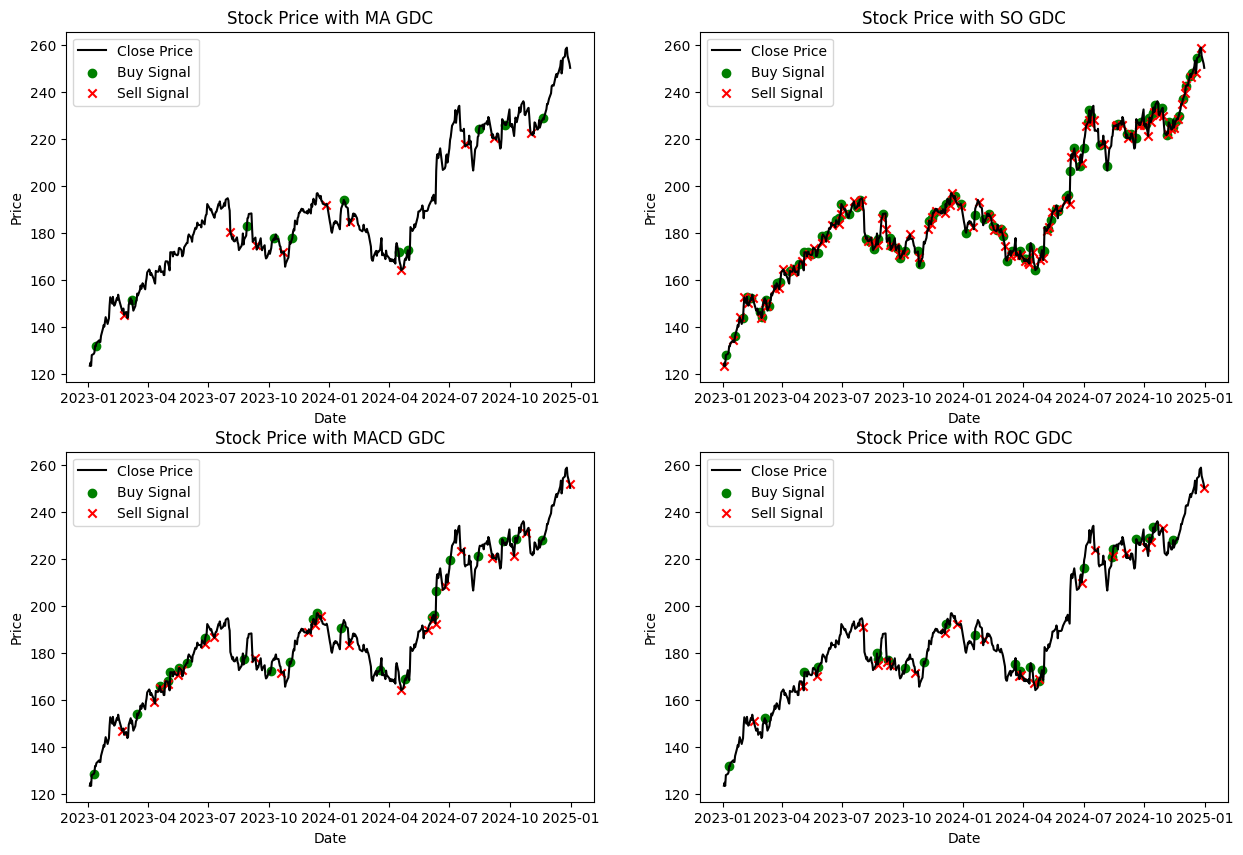

In [37]:
#최적화 안 된 매매신호 시각화
df_not_fit_sig = df_not_fit[(df_not_fit['Date'] >= '2023-01-01') & (df_not_fit['Date'] <= '2025-01-01')]

df_not_fit_sig.set_index('Date', inplace=True)

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# MA_GDC
axs[0, 0].plot(df_not_fit_sig.index, df_not_fit_sig['Close'], label='Close Price', color='black')
buy_ma_signals = df_not_fit_sig[df_not_fit_sig['MA_GDC'] == 1]
sell_ma_signals = df_not_fit_sig[df_not_fit_sig['MA_GDC'] == -1]
axs[0, 0].scatter(buy_ma_signals.index, buy_ma_signals['Close'], marker='o', color='g', label='Buy Signal', alpha=1)
axs[0, 0].scatter(sell_ma_signals.index, sell_ma_signals['Close'], marker='x', color='r', label='Sell Signal', alpha=1)
axs[0, 0].set_title('Stock Price with MA GDC')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Price')
axs[0, 0].legend()

# SO_GDC
axs[0, 1].plot(df_not_fit_sig.index, df_not_fit_sig['Close'], label='Close Price', color='black')
buy_so_signals = df_not_fit_sig[df_not_fit_sig['SO_GDC'] == 1]
sell_so_signals = df_not_fit_sig[df_not_fit_sig['SO_GDC'] == -1]
axs[0, 1].scatter(buy_so_signals.index, buy_so_signals['Close'], marker='o', color='g', label='Buy Signal', alpha=1)
axs[0, 1].scatter(sell_so_signals.index, sell_so_signals['Close'], marker='x', color='r', label='Sell Signal', alpha=1)
axs[0, 1].set_title('Stock Price with SO GDC')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Price')
axs[0, 1].legend()

# MACD_GDC
axs[1, 0].plot(df_not_fit_sig.index, df_not_fit_sig['Close'], label='Close Price', color='black')
buy_macd_signals = df_not_fit_sig[df_not_fit_sig['MACD_GDC'] == 1]
sell_macd_signals = df_not_fit_sig[df_not_fit_sig['MACD_GDC'] == -1]
axs[1, 0].scatter(buy_macd_signals.index, buy_macd_signals['Close'], marker='o', color='g', label='Buy Signal', alpha=1)
axs[1, 0].scatter(sell_macd_signals.index, sell_macd_signals['Close'], marker='x', color='r', label='Sell Signal', alpha=1)
axs[1, 0].set_title('Stock Price with MACD GDC')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Price')
axs[1, 0].legend()

# ROC_GDC
axs[1, 1].plot(df_not_fit_sig.index, df_not_fit_sig['Close'], label='Close Price', color='black')
buy_ROC_signals = df_not_fit_sig[df_not_fit_sig['ROC_GDC'] == 1]
sell_ROC_signals = df_not_fit_sig[df_not_fit_sig['ROC_GDC'] == -1]
axs[1, 1].scatter(buy_ROC_signals.index, buy_ROC_signals['Close'], marker='o', color='g', label='Buy Signal', alpha=1)
axs[1, 1].scatter(sell_ROC_signals.index, sell_ROC_signals['Close'], marker='x', color='r', label='Sell Signal', alpha=1)
axs[1, 1].set_title('Stock Price with ROC GDC')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Price')
axs[1, 1].legend()

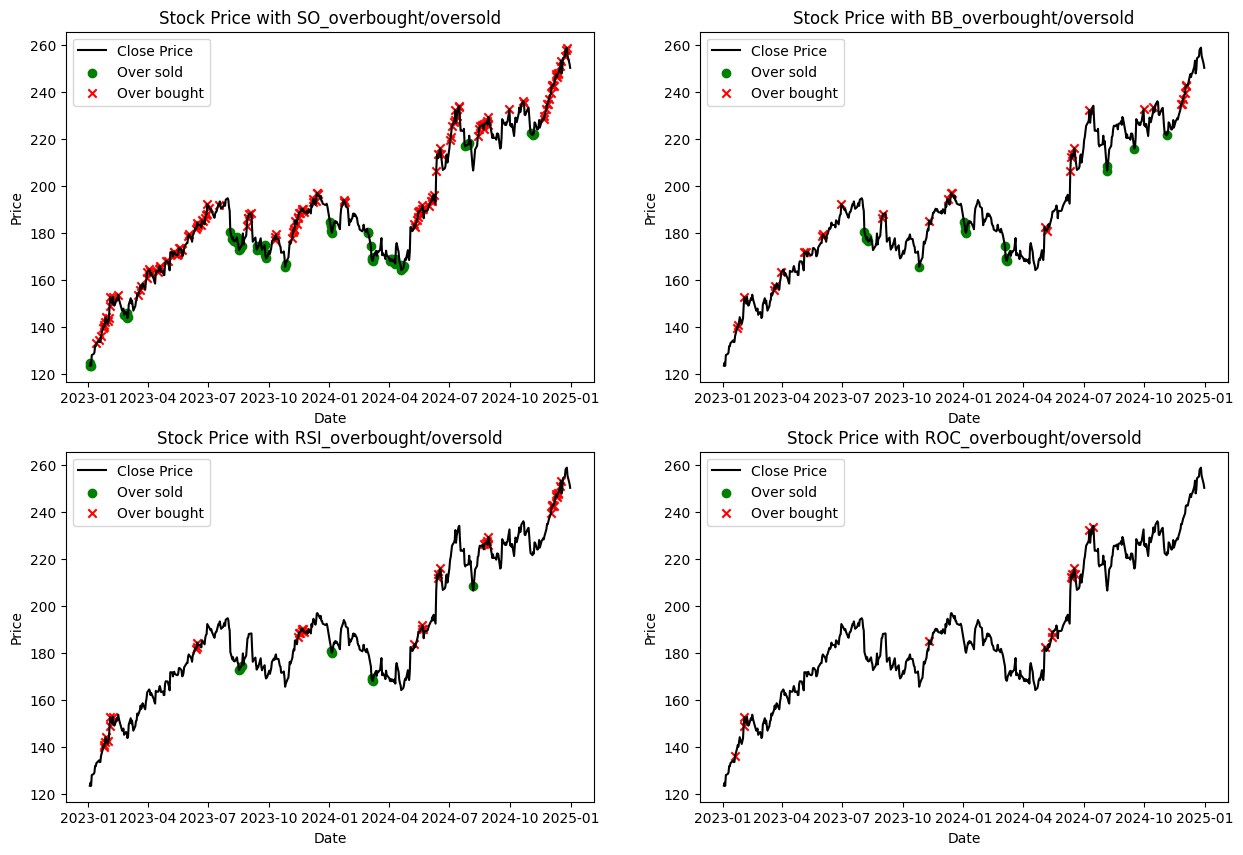

In [38]:
# 최적화 안 된 것 과매수 과매도 시각화

df_not_fit_sig = df_not_fit[(df_not_fit['Date'] >= '2023-01-01') & (df_not_fit['Date'] <= '2025-01-01')]
df_not_fit_sig.set_index('Date', inplace=True)

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# SO_overbought/oversold
axs[0, 0].plot(df_not_fit_sig.index, df_not_fit_sig['Close'], label='Close Price', color='black')
so_oversold = df_not_fit_sig[df_not_fit_sig['SO_momentum'] == 1]   # 과매도
so_overbought = df_not_fit_sig[df_not_fit_sig['SO_momentum'] == -1] # 과매수
axs[0, 0].scatter(so_oversold.index, so_oversold['Close'], marker='o', color='g', label='Over sold', alpha=1)
axs[0, 0].scatter(so_overbought.index, so_overbought['Close'], marker='x', color='r', label='Over bought', alpha=1)
axs[0, 0].set_title('Stock Price with SO_overbought/oversold')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Price')
axs[0, 0].legend()

# Bollinger Bands
axs[0, 1].plot(df_not_fit_sig.index, df_not_fit_sig['Close'], label='Close Price', color='black')
bb_oversold = df_not_fit_sig[df_not_fit_sig['BB_momentum'] == 1]   # 과매도
bb_overbought = df_not_fit_sig[df_not_fit_sig['BB_momentum'] == -1] # 과매수
axs[0, 1].scatter(bb_oversold.index, bb_oversold['Close'], marker='o', color='g', label='Over sold', alpha=1)
axs[0, 1].scatter(bb_overbought.index, bb_overbought['Close'], marker='x', color='r', label='Over bought', alpha=1)
axs[0, 1].set_title('Stock Price with BB_overbought/oversold')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Price')
axs[0, 1].legend()

# RSI_overbought/oversold
axs[1, 0].plot(df_not_fit_sig.index, df_not_fit_sig['Close'], label='Close Price', color='black')
rsi_oversold = df_not_fit_sig[df_not_fit_sig['RSI_momentum'] == 1]   # 과매도
rsi_overbought = df_not_fit_sig[df_not_fit_sig['RSI_momentum'] == -1] # 과매수
axs[1, 0].scatter(rsi_oversold.index, rsi_oversold['Close'], marker='o', color='g', label='Over sold', alpha=1)
axs[1, 0].scatter(rsi_overbought.index, rsi_overbought['Close'], marker='x', color='r', label='Over bought', alpha=1)
axs[1, 0].set_title('Stock Price with RSI_overbought/oversold')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Price')
axs[1, 0].legend()

# ROC_overbought/oversold
axs[1, 1].plot(df_not_fit_sig.index, df_not_fit_sig['Close'], label='Close Price', color='black')
roc_oversold = df_not_fit_sig[df_not_fit_sig['ROC_momentum'] == 1]   # 과매도
roc_overbought = df_not_fit_sig[df_not_fit_sig['ROC_momentum'] == -1] # 과매수
axs[1, 1].scatter(roc_oversold.index, roc_oversold['Close'], marker='o', color='g', label='Over sold', alpha=1)
axs[1, 1].scatter(roc_overbought.index, roc_overbought['Close'], marker='x', color='r', label='Over bought', alpha=1)
axs[1, 1].set_title('Stock Price with ROC_overbought/oversold')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Price')
axs[1, 1].legend()


In [39]:
df_fit=df_price.copy()
create_rsi_momentum(df_fit, best_gene[0])
create_roc_GDC(df_fit, best_gene[1])
create_roc_momentum(df_fit, best_gene[2])
create_MA_GDC(df_fit, best_gene[3], best_gene[4])
create_MACD_GDC(df_fit, best_gene[5], best_gene[6], best_gene[7])
create_SO_GDC(df_fit, best_gene[8])
create_SO_momentum(df_fit, best_gene[9])
create_BB_momentum(df_fit, best_gene[10])

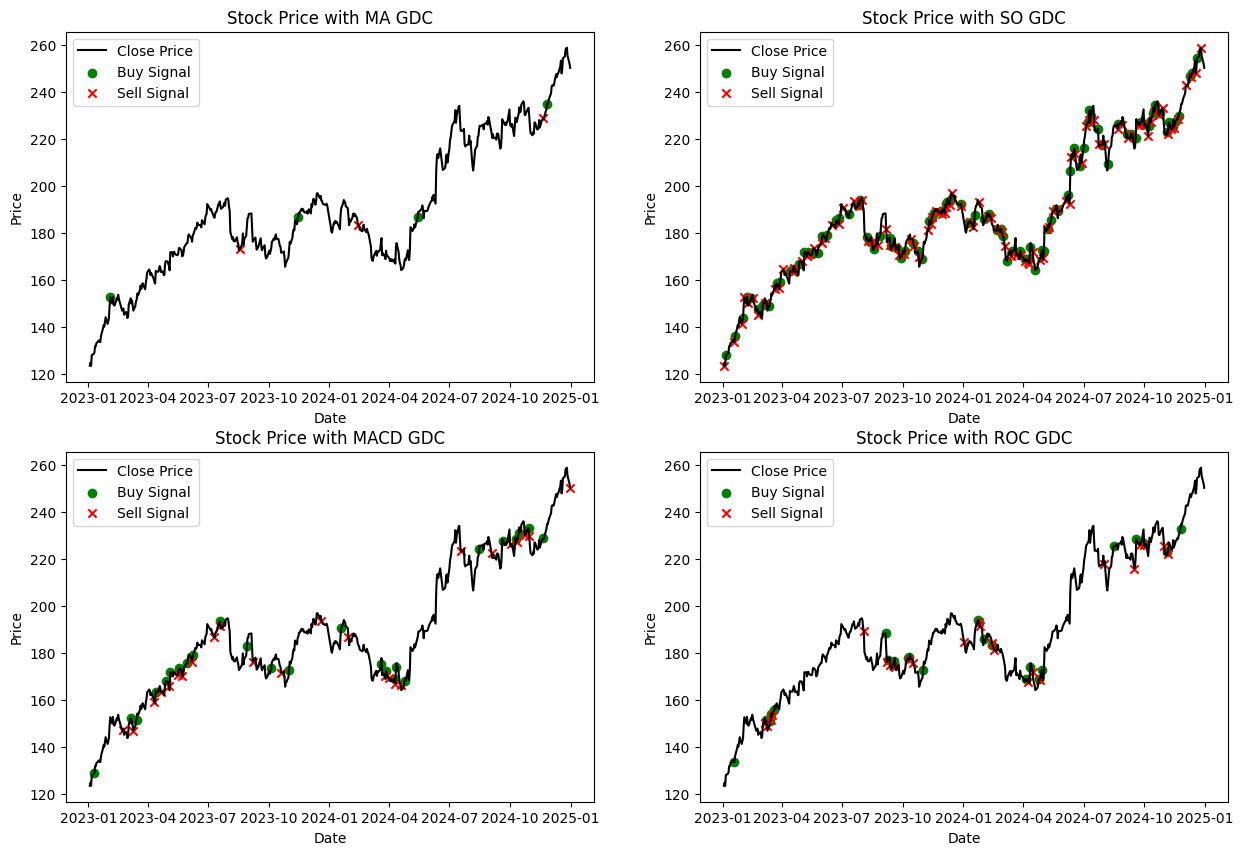

In [40]:
#최적화된 매매신호 시각화
df_fit_sig = df_fit[(df_fit['Date'] >= '2023-01-01') & (df_fit['Date'] <= '2025-01-01')]

df_fit_sig.set_index('Date', inplace=True)

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# MA_GDC
axs[0, 0].plot(df_fit_sig.index, df_fit_sig['Close'], label='Close Price', color='black')
buy_ma_signals = df_fit_sig[df_fit_sig['MA_GDC'] == 1]
sell_ma_signals = df_fit_sig[df_fit_sig['MA_GDC'] == -1]
axs[0, 0].scatter(buy_ma_signals.index, buy_ma_signals['Close'], marker='o', color='g', label='Buy Signal', alpha=1)
axs[0, 0].scatter(sell_ma_signals.index, sell_ma_signals['Close'], marker='x', color='r', label='Sell Signal', alpha=1)
axs[0, 0].set_title('Stock Price with MA GDC')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Price')
axs[0, 0].legend()

# SO_GDC
axs[0, 1].plot(df_fit_sig.index, df_fit_sig['Close'], label='Close Price', color='black')
buy_so_signals = df_fit_sig[df_fit_sig['SO_GDC'] == 1]
sell_so_signals = df_fit_sig[df_fit_sig['SO_GDC'] == -1]
axs[0, 1].scatter(buy_so_signals.index, buy_so_signals['Close'], marker='o', color='g', label='Buy Signal', alpha=1)
axs[0, 1].scatter(sell_so_signals.index, sell_so_signals['Close'], marker='x', color='r', label='Sell Signal', alpha=1)
axs[0, 1].set_title('Stock Price with SO GDC')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Price')
axs[0, 1].legend()

# MACD_GDC
axs[1, 0].plot(df_fit_sig.index, df_fit_sig['Close'], label='Close Price', color='black')
buy_macd_signals = df_fit_sig[df_fit_sig['MACD_GDC'] == 1]
sell_macd_signals = df_fit_sig[df_fit_sig['MACD_GDC'] == -1]
axs[1, 0].scatter(buy_macd_signals.index, buy_macd_signals['Close'], marker='o', color='g', label='Buy Signal', alpha=1)
axs[1, 0].scatter(sell_macd_signals.index, sell_macd_signals['Close'], marker='x', color='r', label='Sell Signal', alpha=1)
axs[1, 0].set_title('Stock Price with MACD GDC')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Price')
axs[1, 0].legend()

# ROC_GDC
axs[1, 1].plot(df_fit_sig.index, df_fit_sig['Close'], label='Close Price', color='black')
buy_ROC_signals = df_fit_sig[df_fit_sig['ROC_GDC'] == 1]
sell_ROC_signals = df_fit_sig[df_fit_sig['ROC_GDC'] == -1]
axs[1, 1].scatter(buy_ROC_signals.index, buy_ROC_signals['Close'], marker='o', color='g', label='Buy Signal', alpha=1)
axs[1, 1].scatter(sell_ROC_signals.index, sell_ROC_signals['Close'], marker='x', color='r', label='Sell Signal', alpha=1)
axs[1, 1].set_title('Stock Price with ROC GDC')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Price')
axs[1, 1].legend()

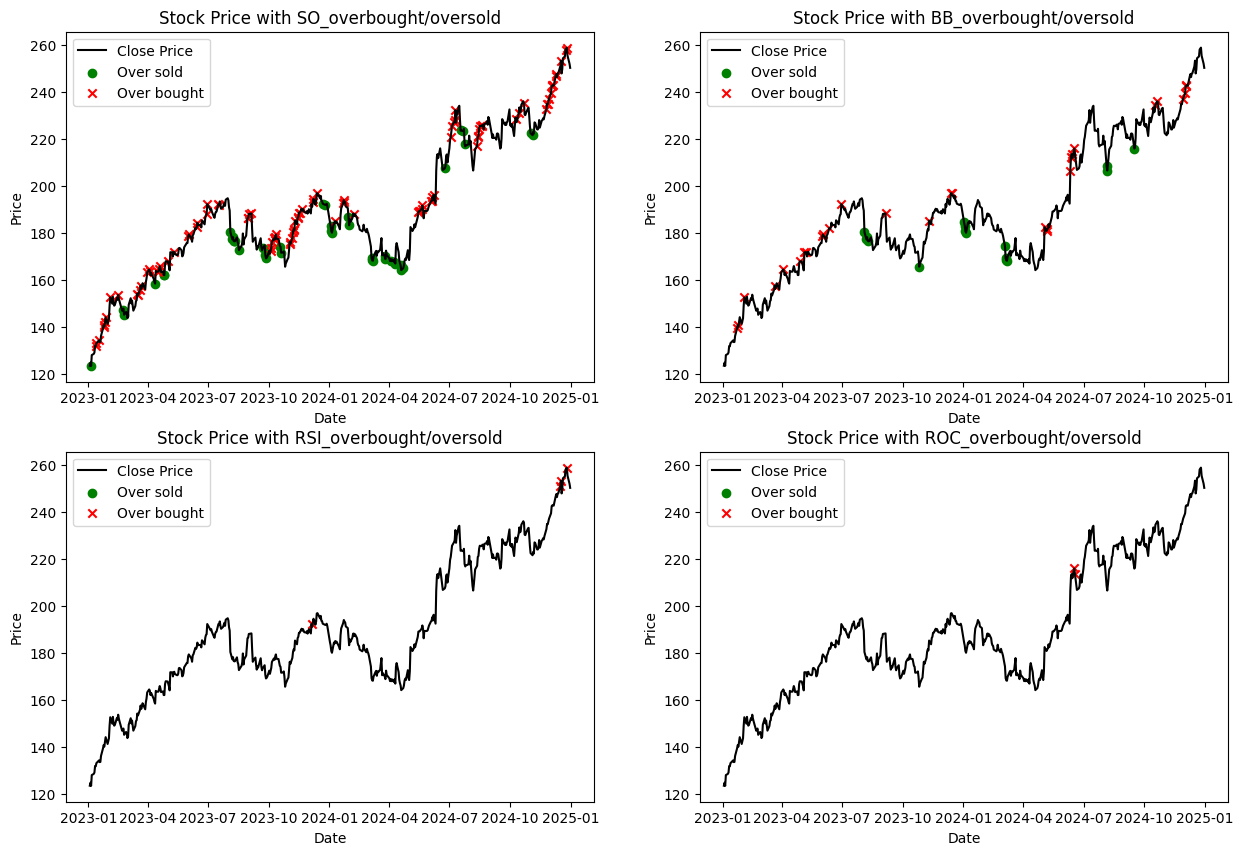

In [41]:
#최적화 된 과매수 과매도 시각화
df_fit_sig = df_fit[(df_fit['Date'] >= '2023-01-01') & (df_fit['Date'] <= '2025-01-01')]
df_fit_sig.set_index('Date', inplace=True)

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# SO_overbought/oversold
axs[0, 0].plot(df_fit_sig.index, df_fit_sig['Close'], label='Close Price', color='black')
so_oversold = df_fit_sig[df_fit_sig['SO_momentum'] == 1]   # 과매도
so_overbought = df_fit_sig[df_fit_sig['SO_momentum'] == -1] # 과매수
axs[0, 0].scatter(so_oversold.index, so_oversold['Close'], marker='o', color='g', label='Over sold', alpha=1)
axs[0, 0].scatter(so_overbought.index, so_overbought['Close'], marker='x', color='r', label='Over bought', alpha=1)
axs[0, 0].set_title('Stock Price with SO_overbought/oversold')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Price')
axs[0, 0].legend()

# Bollinger Bands
axs[0, 1].plot(df_fit_sig.index, df_fit_sig['Close'], label='Close Price', color='black')
bb_oversold = df_fit_sig[df_fit_sig['BB_momentum'] == 1]   # 과매도
bb_overbought = df_fit_sig[df_fit_sig['BB_momentum'] == -1] # 과매수
axs[0, 1].scatter(bb_oversold.index, bb_oversold['Close'], marker='o', color='g', label='Over sold', alpha=1)
axs[0, 1].scatter(bb_overbought.index, bb_overbought['Close'], marker='x', color='r', label='Over bought', alpha=1)
axs[0, 1].set_title('Stock Price with BB_overbought/oversold')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Price')
axs[0, 1].legend()

# RSI_overbought/oversold
axs[1, 0].plot(df_fit_sig.index, df_fit_sig['Close'], label='Close Price', color='black')
rsi_oversold = df_fit_sig[df_fit_sig['RSI_momentum'] == 1]   # 과매도
rsi_overbought = df_fit_sig[df_fit_sig['RSI_momentum'] == -1] # 과매수
axs[1, 0].scatter(rsi_oversold.index, rsi_oversold['Close'], marker='o', color='g', label='Over sold', alpha=1)
axs[1, 0].scatter(rsi_overbought.index, rsi_overbought['Close'], marker='x', color='r', label='Over bought', alpha=1)
axs[1, 0].set_title('Stock Price with RSI_overbought/oversold')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Price')
axs[1, 0].legend()

# ROC_overbought/oversold
axs[1, 1].plot(df_fit_sig.index, df_fit_sig['Close'], label='Close Price', color='black')
roc_oversold = df_fit_sig[df_fit_sig['ROC_momentum'] == 1]   # 과매도
roc_overbought = df_fit_sig[df_fit_sig['ROC_momentum'] == -1] # 과매수
axs[1, 1].scatter(roc_oversold.index, roc_oversold['Close'], marker='o', color='g', label='Over sold', alpha=1)
axs[1, 1].scatter(roc_overbought.index, roc_overbought['Close'], marker='x', color='r', label='Over bought', alpha=1)
axs[1, 1].set_title('Stock Price with ROC_overbought/oversold')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Price')
axs[1, 1].legend()


In [42]:
# 코사인 유사도 합 계산
signals = ['MA_GDC', 'SO_GDC', 'SO_momentum', 'MACD_GDC',
               'BB_momentum', 'RSI_momentum', 'ROC_GDC', 'ROC_momentum']

not_fit_similarities = [compute_cosine_similarity(df_not_fit, signal) for signal in signals]
fit_similarities = [compute_cosine_similarity(df_fit, signal) for signal in signals]

print('not_fit_similarities_sum:' ,-sum(not_fit_similarities))
print('fit_similarities_sum:' ,-sum(fit_similarities))

not_fit_similarities_sum: 0.020881912869218686
fit_similarities_sum: -0.10594869690647916


##코사인 유사도를 활용한 휴리스틱 함수 결과 매우 성능이 좋지않음을 확인##
코사인 유사도는 1의 값을 가질 수록 좋다, 모든 지표가 0에 가까우므로 무의미.

In [43]:
for signal, sim in zip(signals, not_fit_similarities):
    print(f"{signal}: {sim:.4f}")

MA_GDC: 0.0153
SO_GDC: -0.0010
SO_momentum: -0.0702
MACD_GDC: 0.0151
BB_momentum: -0.0143
RSI_momentum: -0.0238
ROC_GDC: 0.0303
ROC_momentum: 0.0277


In [44]:
for signal, sim in zip(signals, fit_similarities):
    print(f"{signal}: {sim:.4f}")

MA_GDC: 0.0489
SO_GDC: 0.0062
SO_momentum: -0.0425
MACD_GDC: 0.0400
BB_momentum: -0.0028
RSI_momentum: -0.0178
ROC_GDC: 0.0323
ROC_momentum: 0.0418
